# Plot Generation Notebook for GECCO 2025 Paper

In [1]:
import collections
import json
import os
import sys
from typing import Dict
from tqdm import tqdm

sys.path.append("src/")

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from aes_lipi.anns.prune_ann import get_n_params
from aes_lipi.utilities.utilities import (
    load_data_and_autoencoder,
    measure_ae_quality,
)

## Helper Functions

In [2]:
def get_configuration_files(param_dir: str) -> Dict[str, str]:
    configuration_files = {}
    for root, _, files in os.walk(param_dir):
        for file_name in files:
            if file_name == "params.json":
                key = os.path.basename(root)
                configuration_files[key] = os.path.join(root, file_name)

    return configuration_files

In [3]:
def get_display_name(display_name: str, name_map: Dict[str, str]) -> str:
    NAME_MAP = {
        "dataset_name": "",
        "binary_clustering": "bc",
        "solution_concept": "sc",
        "population_size": "ps",
        "radius": "r",
        "learning_rate": "lr",
        "epoch-node": "en",
        "True": "T",
        "False": "F",
        "environment": "env",
        "AutoencoderBinaryClustering": "AE",
        "batch_size": "bs",
        "cell_evaluation": "ce",
        "checkpoint_every_update": "",
        "10_100_1000": "10_1000",
        "ann_canonical": "can",
        "all_vs_all": "all",
        "lipi_simple": "simp",
    }
    NAME_MAP.update(name_map)
    for k, v in NAME_MAP.items():
        display_name = display_name.replace(k, v)

    if display_name.split("_")[-2].startswith("2025-"):
        display_name = "_".join(display_name.split("_")[:-2])

    return display_name

In [4]:
def analyse_trials(
    root_dir: str,
    configuration_files: dict[str, str],
    name: str,
    name_map: Dict[str, str] = {},
) -> tuple[pd.DataFrame, str]:
    # TODO messy
    output_dir = os.path.join(root_dir, f"test_experiment_analysis_{name}")
    os.makedirs(output_dir, exist_ok=True)
    dfs = []
    quality_scores = collections.defaultdict(list)
    for directory in tqdm(os.listdir(root_dir)):
        if not directory.startswith("trial_"):
            continue
        file_path = os.path.join(root_dir, directory, "stats.jsonl")
        trial_param_path = configuration_files.get(directory)
        if trial_param_path is None:
            continue

        try:
            with open(trial_param_path, "r") as fd:
                trial_params = json.load(fd)
        except ValueError as e:
            print(f"{e} for loading {trial_param_path}")
            continue

        epochs = trial_params["epochs"]
        trial_nr = int(directory.split("_")[1])
        try:
            _df = pd.read_json(file_path, orient="records", lines=True)
        except ValueError as e:
            print(f"{e} for {file_path}")
            continue

        _df["trial_param_path"] = trial_param_path
        _df["prune_method"] = trial_params["prune_method"]
        _df["prune_schedule"] = trial_params["prune_schedule"]
        _df["prune_probability"] = trial_params["prune_probability"]
        _df["prune_amount"] = trial_params["prune_amount"]
        _df["trial_nr"] = [trial_nr] * len(_df)
        dir_name = "_".join(directory.split("_")[2:])
        _df["directory"] = dir_name
        # TODO Messy display name
        display_name = get_display_name(dir_name, name_map)
        _df["display_name"] = display_name
        dfs.append(_df)
        # Measure quality
        ann_path = os.path.join(root_dir, directory, "checkpoints", f"t{epochs}_ae.pt")
        _df["final_ann_path"] = ann_path
        dataset_name = trial_params["dataset_name"]
        train_loader, test_loader, width, height, ae = load_data_and_autoencoder(
            trial_params["batch_size"],
            ann_path,
            trial_params["environment"],
            dataset_name,
            data_loader_str="test",
        )
        n_nodes = {
            "encoder": get_n_params(ae.encoder),
            "decoder": get_n_params(ae.decoder),
            "ae": get_n_params(ae.encoder) + get_n_params(ae.decoder),
        }
        try:
            quality = measure_ae_quality(
                ann_path,
                trial_params["environment"],
                trial_params["batch_size"],
                dataset_name,
            )
        except Exception as e:
            print(f"{e} for {trial_param_path}")
            quality = {}

        if not quality:
            continue
        for key, value in quality.items():
            trial_id = np.multiply(np.ones(value.shape), trial_nr)
            values = np.hstack((value, trial_id))
            quality_scores[key].append(values)

    # if quality_scores:
    #     # TODO Hacky

    #     key = "L1"
    #     qualities = np.vstack(quality_scores[key])
    #     columns = [key, "Trial"]
    #     df = pd.DataFrame(qualities, columns=columns)
    #     sns.boxplot(df, x=key, hue="Trial")
    #     out_path = os.path.join(output_dir, f"t{epochs}_{key}_bar.png")
    #     plt.tight_layout()
    #     plt.savefig(out_path)
    #     plt.clf()
    #     out_path = os.path.join(output_dir, f"t{epochs}_{key}.json")
    #     df.to_json(out_path)

    df = pd.concat(dfs)
    df = df.reset_index(drop=True)
    out_file = os.path.join(output_dir, "stats.jsonl")
    exp_dir = output_dir
    df.to_json(out_file, orient="records", lines=True)

    df = get_prune_method_names(df)

    return df, exp_dir, n_nodes

In [5]:
def get_prune_method_names(df):
    df["prune_method"] = df["prune_method"].apply(
        lambda x: lexi_name if "lexicase" in x else x
    )
    df["prune_method"] = df["prune_method"].apply(
        lambda x: activation_name if "activation" in x else x
    )
    df["prune_method"] = df["prune_method"].apply(
        lambda x: random_name if "random" in x else x
    )
    return df

## Settings

In [6]:
# Data "prune_method" Renaming Settings
lexi_name = "Conjunctive"
activation_name = "Variance"
random_name = "Random"

# Plot Style Settings
palette = sns.color_palette("colorblind")

color_prune_method = {
    "None": palette[0],
    lexi_name: palette[3],
    random_name: palette[2],
    activation_name: palette[4],
}

color_prune_schedule = {
    "fixed": palette[0],
    "increase": "purple",
    "decrease": palette[2],
    "exponential": palette[3],
    "final_n": palette[6],
    "population": "gold",
}

sns.set(style="whitegrid")
sns.set_context("paper")
sns.set_style("ticks")

# General Plot Settings
L1_ticks = np.arange(0, 0.55, 0.05)
n_prune_ticks = np.arange(0, 35000, 5000)
n_prune_ind_ticks = np.arange(0, 65000, 5000)
L1_epoch_ticks = np.arange(0, 500, 100)

img_dir = "./paper_runs/all_figures/"
fig_size = (12, 8)
font_size = 24
font_name = "Times New Roman"

# Parameter Counts
dec_params = 31330
enc_params = 30340
sm_dec_params = 31090
sm_enc_params = 30092


## Best of Lipi L1 Lineplot

100%|██████████| 121/121 [00:06<00:00, 18.12it/s]


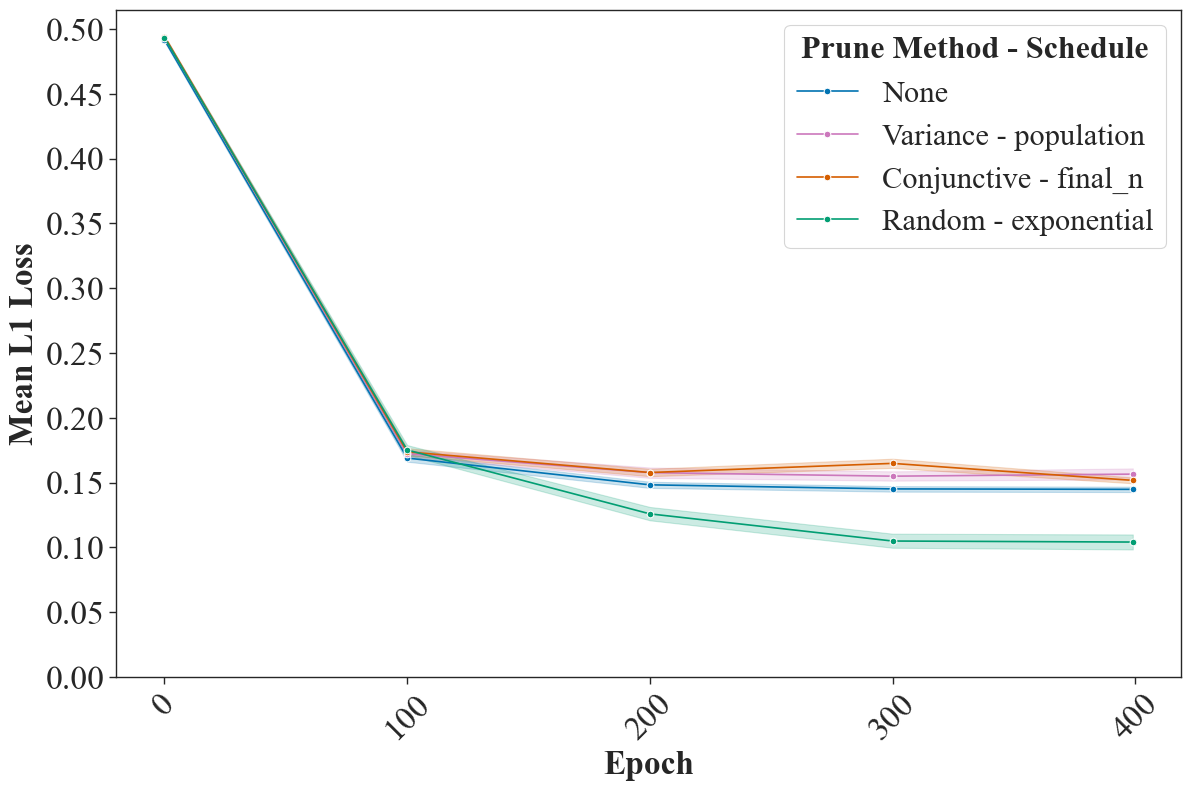

<Figure size 640x480 with 0 Axes>

In [7]:
param_dir = root_dir = "./paper_runs/best_of_lipi/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

label_map = {
    lexi_name: lexi_name + " - final_n",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - population",
}
df["prune_method_schedule"] = df["prune_method"].replace(label_map)

color_prune_method_schedule = {
    "None": color_prune_method["None"],
    label_map[lexi_name]: color_prune_method[lexi_name],
    label_map[random_name]: color_prune_method[random_name],
    label_map[activation_name]: color_prune_method[activation_name],
}

prune_methods = df["prune_method_schedule"].unique()
hue_order = ["None"] + [method for method in prune_methods if method != "None"]

# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_method_schedule",
    marker="o",
    hue_order=hue_order,
    palette=color_prune_method_schedule,
)

legend = plt.legend(
    title="Prune Method - Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_lipi_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Best of Canonical L1 Lineplot

100%|██████████| 121/121 [00:05<00:00, 21.89it/s]


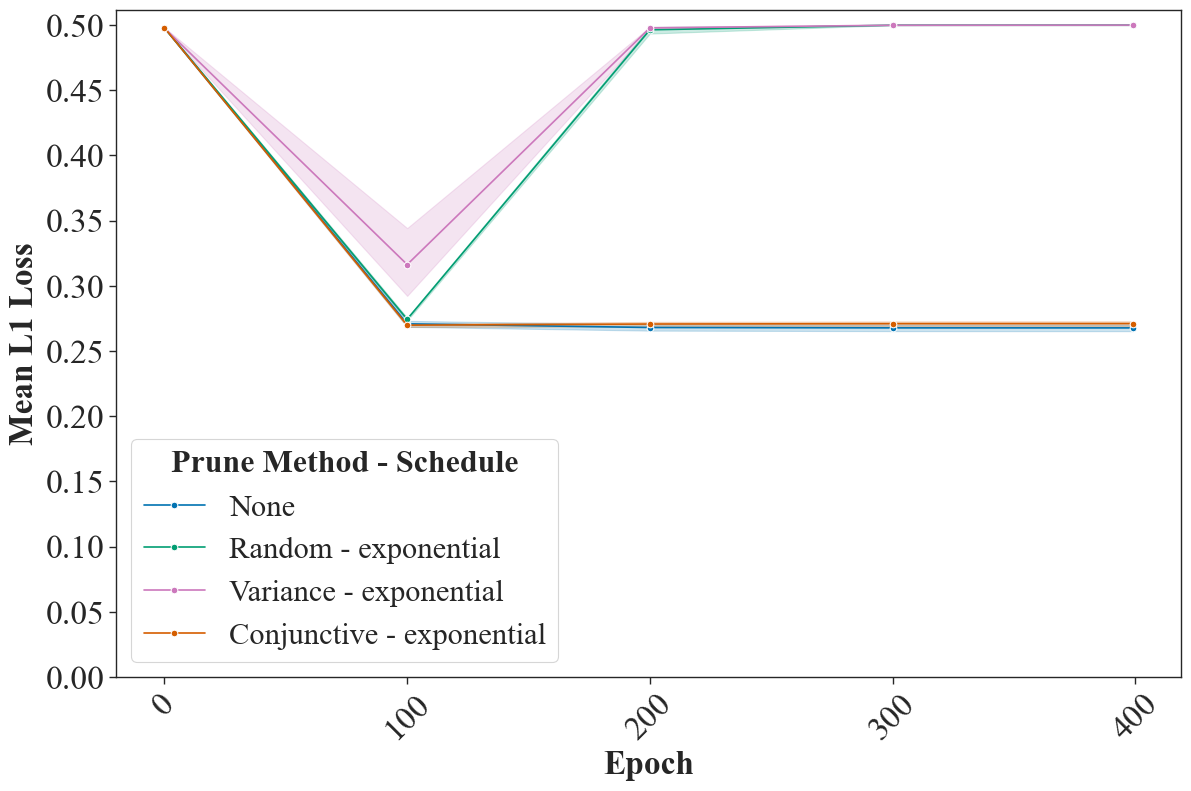

<Figure size 640x480 with 0 Axes>

In [8]:
param_dir = root_dir = "./paper_runs/best_of_canonical/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

label_map = {
    lexi_name: lexi_name + " - exponential",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - exponential",
}
df["prune_method_schedule"] = df["prune_method"].replace(label_map)

color_prune_method_schedule = {
    "None": color_prune_method["None"],
    label_map[lexi_name]: color_prune_method[lexi_name],
    label_map[random_name]: color_prune_method[random_name],
    label_map[activation_name]: color_prune_method[activation_name],
}

prune_methods = df["prune_method_schedule"].unique()
hue_order = ["None"] + [method for method in prune_methods if method != "None"]


# Plot data
plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_method_schedule",
    marker="o",
    hue_order=hue_order,
    palette=color_prune_method_schedule,
)

legend = plt.legend(
    title="Prune Method - Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_canonical_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Best of Lipi-Small L1 Lineplot

In [ ]:
# param_dir = root_dir = "./paper_runs/extra_small_lipi"
# configuration_files = get_configuration_files(param_dir)  # noqa: F821
# name_map = {}

# main_df, _, n_nodes = analyse_trials(  # noqa: F821
#     root_dir, configuration_files, "GECCO_2025", name_map
# )
# df = main_df

# label_map = {
#     lexi_name: lexi_name + " - exponential",
#     random_name: random_name + " - exponential",
#     activation_name: activation_name + " - exponential",
# }
# df["prune_method_schedule"] = df["prune_method"].replace(label_map)

# color_prune_method_schedule = {
#     "None": color_prune_method["None"],
#     label_map[lexi_name]: color_prune_method[lexi_name],
#     label_map[random_name]: color_prune_method[random_name],
#     label_map[activation_name]: color_prune_method[activation_name],
# }

# prune_methods = df["prune_method_schedule"].unique()
# hue_order = ["None"] + [method for method in prune_methods if method != "None"]


# # Plot data
# plt.figure(figsize=fig_size)

# g = sns.lineplot(
#     data=df,
#     x="iteration",
#     y="mean_L1",
#     hue="prune_method_schedule",
#     marker="o",
#     hue_order=hue_order,
#     palette=color_prune_method_schedule,
# )

# legend = plt.legend(
#     title="Prune Method - Schedule",
#     title_fontsize=font_size - 1,
#     prop={"family": font_name, "size": font_size - 2},
# )
# legend.get_title().set_fontweight("bold")
# legend.get_title().set_fontname(font_name)

# plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
# plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


# plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
# plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
# plt.tight_layout()
# out_path = os.path.join(img_dir, "lipi_extra_small_L1_line.png")
# plt.savefig(out_path)
# plt.show()
# plt.clf()

  0%|          | 0/31 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for EncoderBinaryClusteringSmall:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([12, 1000]) from checkpoint, the shape in current model is torch.Size([30, 1000]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([2, 12]) from checkpoint, the shape in current model is torch.Size([2, 30]).

In [ ]:
# param_dir = root_dir = "./paper_runs/lipi_extra_extra_small/"
# configuration_files = get_configuration_files(param_dir)  # noqa: F821
# name_map = {}

# main_df, _, n_nodes = analyse_trials(  # noqa: F821
#     root_dir, configuration_files, "GECCO_2025", name_map
# )
# df = main_df

# label_map = {
#     lexi_name: lexi_name + " - exponential",
#     random_name: random_name + " - exponential",
#     activation_name: activation_name + " - exponential",
# }
# df["prune_method_schedule"] = df["prune_method"].replace(label_map)

# color_prune_method_schedule = {
#     "None": color_prune_method["None"],
#     label_map[lexi_name]: color_prune_method[lexi_name],
#     label_map[random_name]: color_prune_method[random_name],
#     label_map[activation_name]: color_prune_method[activation_name],
# }

# prune_methods = df["prune_method_schedule"].unique()
# hue_order = ["None"] + [method for method in prune_methods if method != "None"]


# # Plot data
# plt.figure(figsize=fig_size)

# g = sns.lineplot(
#     data=df,
#     x="iteration",
#     y="mean_L1",
#     hue="prune_method_schedule",
#     marker="o",
#     hue_order=hue_order,
#     palette=color_prune_method_schedule,
# )

# legend = plt.legend(
#     title="Prune Method - Schedule",
#     title_fontsize=font_size - 1,
#     prop={"family": font_name, "size": font_size - 2},
# )
# legend.get_title().set_fontweight("bold")
# legend.get_title().set_fontname(font_name)

# plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
# plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


# plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
# plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
# plt.tight_layout()
# out_path = os.path.join(img_dir, "lipi_extra_extra_small_L1_line.png")
# plt.savefig(out_path)
# plt.show()
# plt.clf()

100%|██████████| 122/122 [00:07<00:00, 15.89it/s]


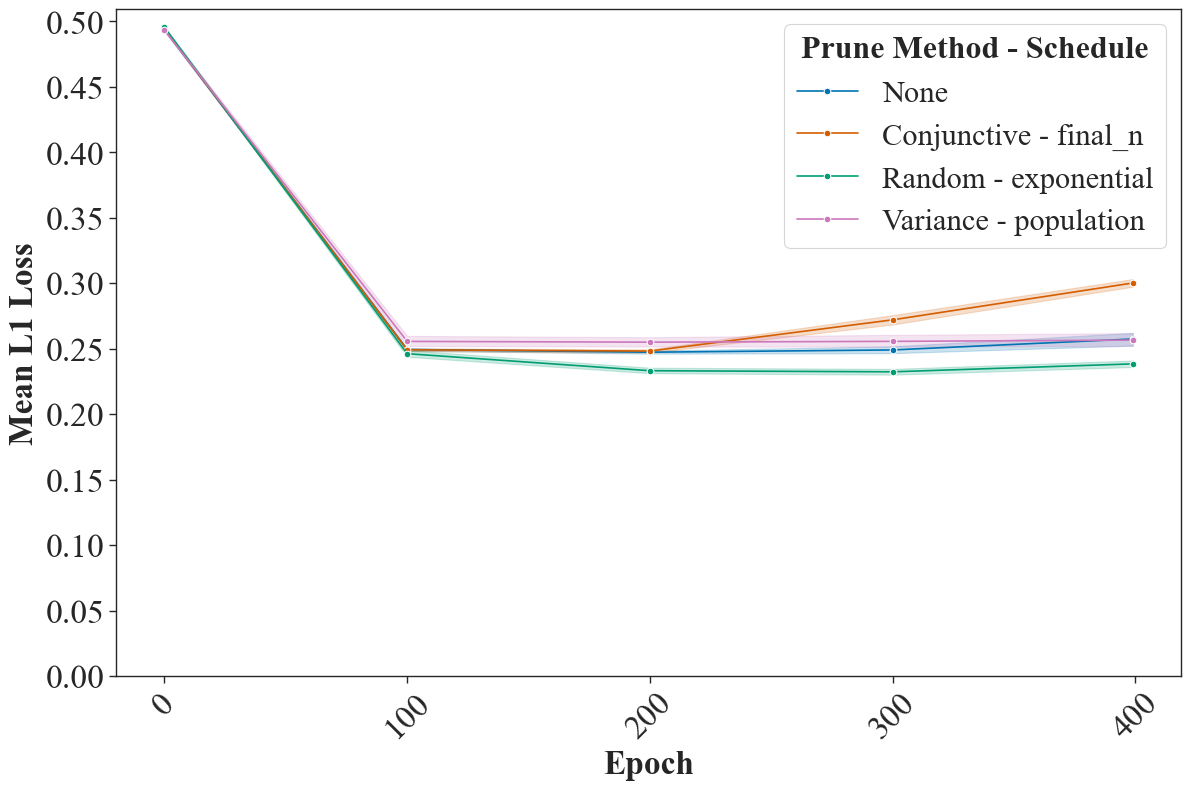

<Figure size 640x480 with 0 Axes>

In [10]:
param_dir = root_dir = "./paper_runs/best_of_lipi_small/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

label_map = {
    lexi_name: lexi_name + " - final_n",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - population",
}
df["prune_method_schedule"] = df["prune_method"].replace(label_map)

color_prune_method_schedule = {
    "None": color_prune_method["None"],
    label_map[lexi_name]: color_prune_method[lexi_name],
    label_map[random_name]: color_prune_method[random_name],
    label_map[activation_name]: color_prune_method[activation_name],
}

prune_methods = df["prune_method_schedule"].unique()
hue_order = ["None"] + [method for method in prune_methods if method != "None"]


# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_method_schedule",
    marker="o",
    hue_order=hue_order,
    palette=color_prune_method_schedule,
)

legend = plt.legend(
    title="Prune Method - Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_lipi_small_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Best of Lipi, Lipi-Small, and Canonical L1 Lineplot

100%|██████████| 91/91 [00:04<00:00, 18.42it/s]


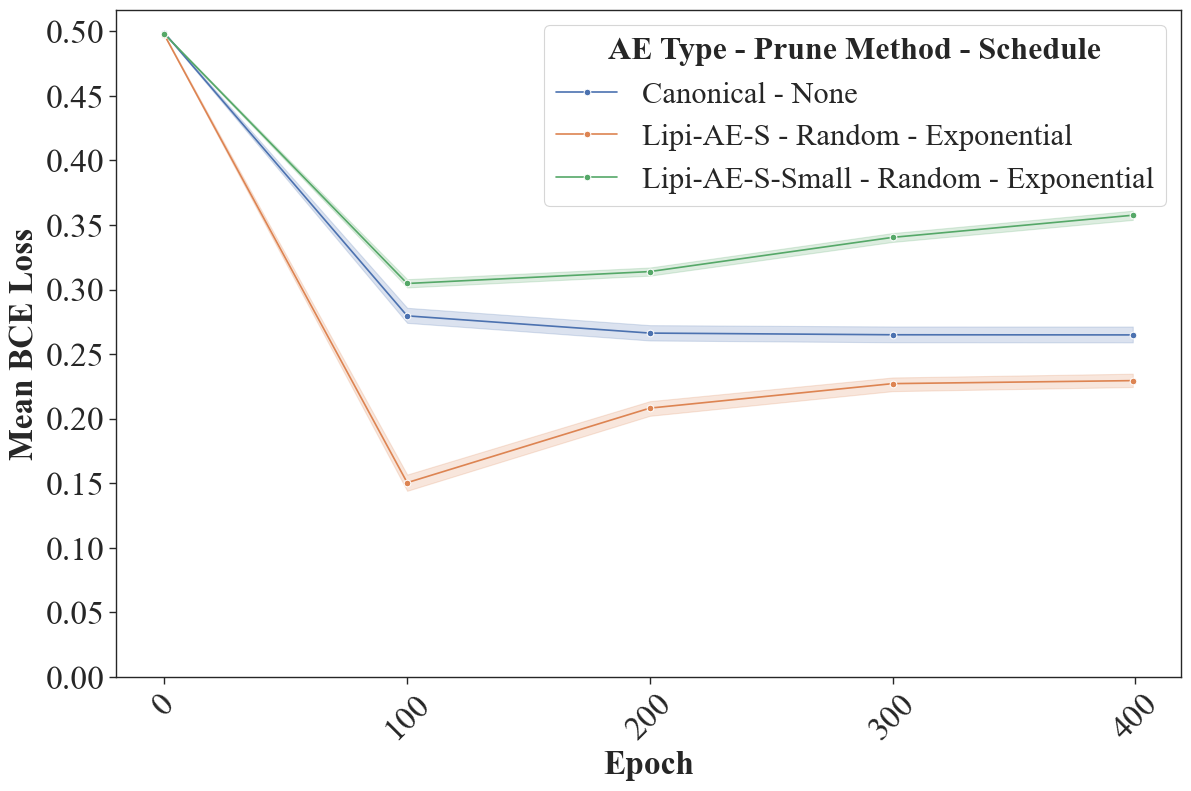

<Figure size 640x480 with 0 Axes>

In [11]:
param_dir = root_dir = "./paper_runs/bce_best_of_best/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

df["display_name"] = df["display_name"].apply(
    lambda x: "Lipi-AE-S-Small - Random - Exponential" if "en_AE_Small" in x else x
)
df["display_name"] = df["display_name"].apply(
    lambda x: "Lipi-AE-S - Random - Exponential" if "ce_simp" in x else x
)
df["display_name"] = df["display_name"].apply(
    lambda x: "Canonical - None" if "ce_can" in x else x
)

prune_methods = df["display_name"].unique()
hue_order = ["Canonical - None"] + [
    method for method in prune_methods if method != "Canonical - None"
]

# Plot data
plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="display_name",
    marker="o",
    hue_order=hue_order,
)

legend = plt.legend(
    title="AE Type - Prune Method - Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean BCE Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_best_BCE_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

100%|██████████| 91/91 [00:05<00:00, 18.13it/s]


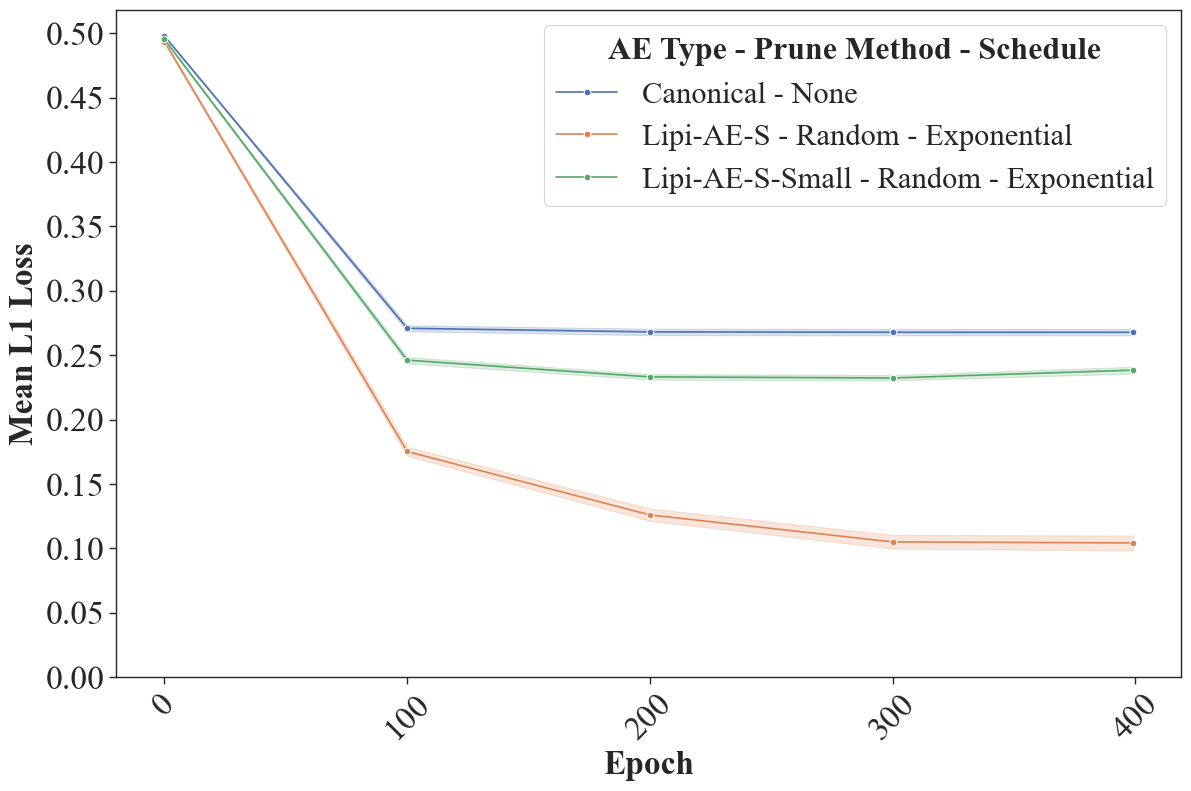

<Figure size 640x480 with 0 Axes>

In [12]:
param_dir = root_dir = "./paper_runs/best_of_best/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

df["display_name"] = df["display_name"].apply(
    lambda x: "Lipi-AE-S-Small - Random - Exponential" if "en_AE_Small" in x else x
)
df["display_name"] = df["display_name"].apply(
    lambda x: "Lipi-AE-S - Random - Exponential" if "ce_simp" in x else x
)
df["display_name"] = df["display_name"].apply(
    lambda x: "Canonical - None" if "ce_can" in x else x
)

prune_methods = df["display_name"].unique()
hue_order = ["Canonical - None"] + [
    method for method in prune_methods if method != "Canonical - None"
]

# Plot data
plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="display_name",
    marker="o",
    hue_order=hue_order,
)

legend = plt.legend(
    title="AE Type - Prune Method - Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_best_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Pruning Schedule Sweep for CONJUNCTIVE

100%|██████████| 181/181 [00:10<00:00, 17.65it/s]


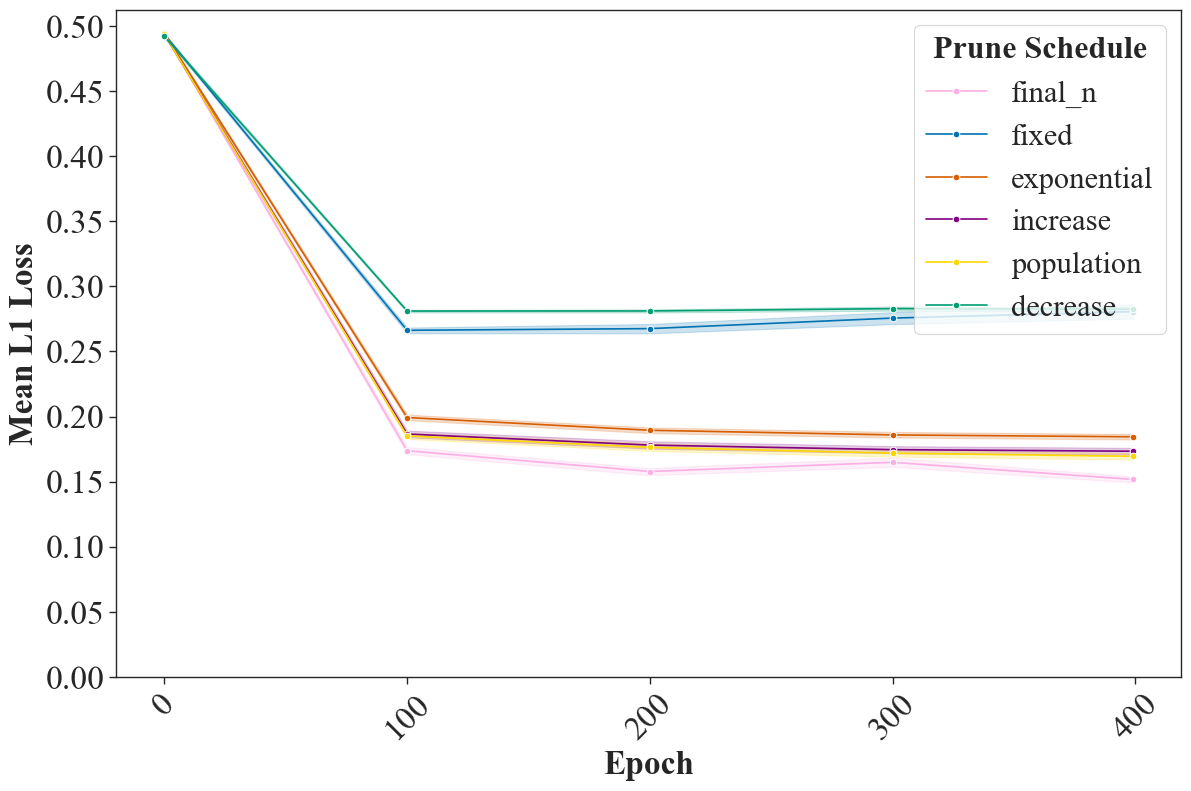

<Figure size 640x480 with 0 Axes>

In [13]:
param_dir = root_dir = "./paper_runs/schedules_lexi/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

# Plot data
plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_schedule",
    marker="o",
    palette=color_prune_schedule,
)

legend = plt.legend(
    title="Prune Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
    loc="upper right",
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "schedules_lexi_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Pruning Schedule Sweep for RANDOM

100%|██████████| 181/181 [00:10<00:00, 18.01it/s]


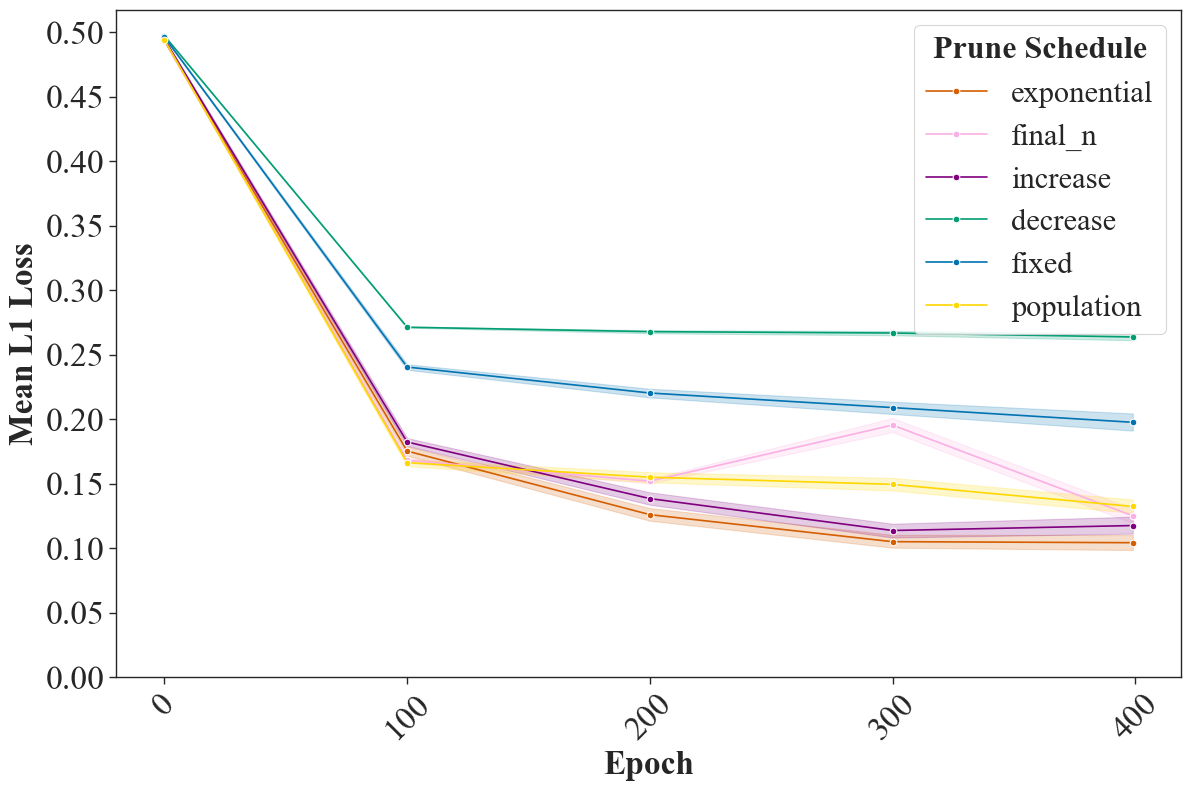

<Figure size 640x480 with 0 Axes>

In [14]:
param_dir = root_dir = "./paper_runs/schedules_random/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_schedule",
    marker="o",
    palette=color_prune_schedule,
)

legend = plt.legend(
    title="Prune Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
    loc="upper right",
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "schedules_random_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Pruning Schedule Sweep of VARIANCE

100%|██████████| 181/181 [00:09<00:00, 18.15it/s]


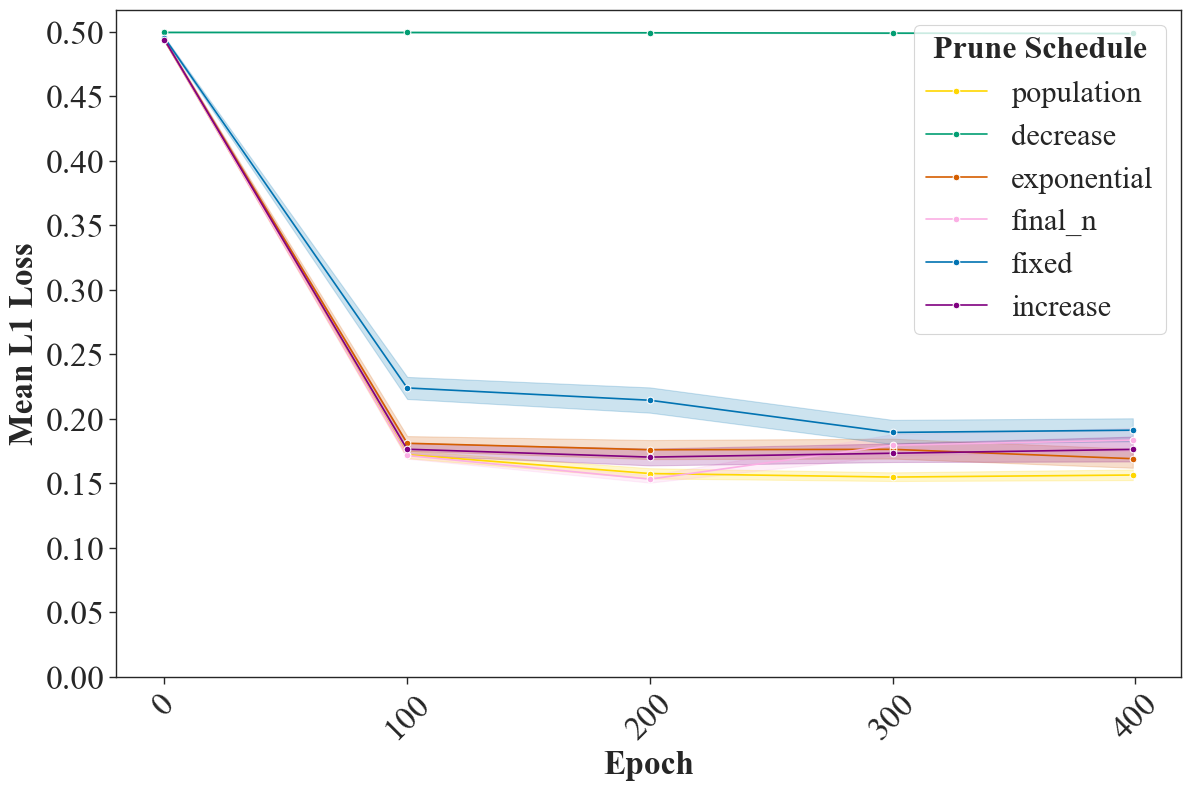

<Figure size 640x480 with 0 Axes>

In [15]:
param_dir = root_dir = "./paper_runs/schedules_activation/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=df,
    x="iteration",
    y="mean_L1",
    hue="prune_schedule",
    marker="o",
    palette=color_prune_schedule,
)

legend = plt.legend(
    title="Prune Schedule",
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
    loc="upper right",
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Mean L1 Loss", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(L1_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "schedules_activation_L1_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Network Size During Training Lineplot for Best of Lipi

100%|██████████| 121/121 [00:06<00:00, 18.55it/s]
/var/folders/r0/t6sd88jj6359qpsqf66ydjcr0000gn/T/ipykernel_88023/569533453.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = "Encoder"
/var/folders/r0/t6sd88jj6359qpsqf66ydjcr0000gn/T/ipykernel_88023/569533453.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_prune"] = enc_params - df["n_pruned_encoder"]


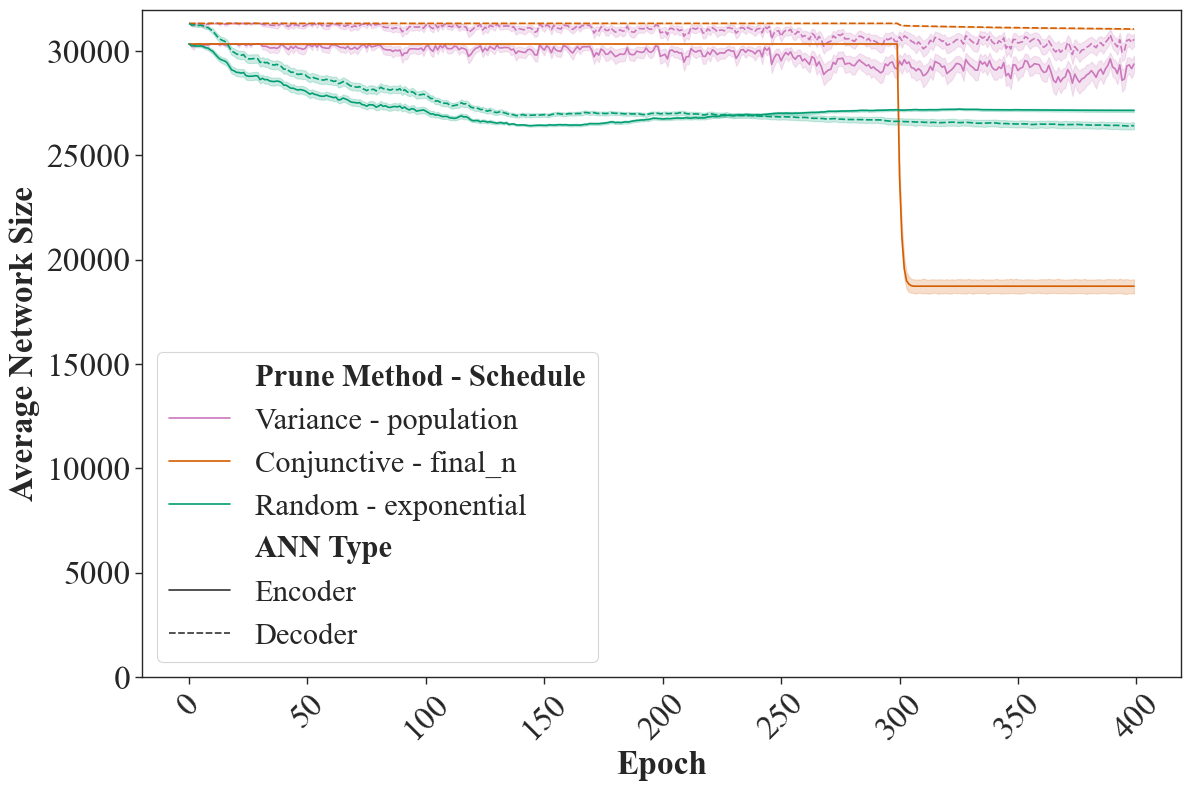

<Figure size 640x480 with 0 Axes>

In [16]:
param_dir = root_dir = "./paper_runs/best_of_lipi/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df


label_map = {
    lexi_name: lexi_name + " - final_n",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - population",
}
df["prune_method_schedule"] = df["prune_method"].replace(label_map)

color_prune_method_schedule = {
    label_map[lexi_name]: color_prune_method[lexi_name],
    label_map[random_name]: color_prune_method[random_name],
    label_map[activation_name]: color_prune_method[activation_name],
}

prune_methods = df["prune_method_schedule"].unique()
hue_order = [method for method in prune_methods if method != "None"]

df = df[df["prune_method"] != "None"]

df["type"] = "Encoder"
df["n_prune"] = enc_params - df["n_pruned_encoder"]
df2 = df.copy()
df2["type"] = "Decoder"
df2["n_prune"] = dec_params - df2["n_pruned_decoder"]
big_df = pd.concat([df, df2])

# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=big_df,
    x="iteration",
    y="n_prune",
    hue="prune_method_schedule",
    hue_order=hue_order,
    palette=color_prune_method_schedule,
    style="type",
)

# # df['type'] = ["Decoder"]*df.shape[0]
# g = sns.lineplot(data=df2, x="iteration", y="n_pruned_decoder", hue="prune_method_schedule", hue_order=hue_order, palette=color_prune_method_schedule, style='type')
handles, labels = g.get_legend_handles_labels()


legend = plt.legend(
    handles=handles,
    labels=labels,
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

for text in legend.get_texts():
    if text.get_text() == "type":
        text.set_text("ANN Type")
        text.set_fontweight("bold")
    elif text.get_text() == "prune_method_schedule":
        text.set_text("Prune Method - Schedule")
        text.set_fontweight("bold")

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel(
    "Average Network Size", fontsize=font_size, fontweight="bold", fontname=font_name
)


plt.xticks(rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(n_prune_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_lipi_n_prune.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Network Size During Training Lineplot for Best of Canonical

100%|██████████| 121/121 [00:05<00:00, 21.03it/s]
/var/folders/r0/t6sd88jj6359qpsqf66ydjcr0000gn/T/ipykernel_88023/1180181905.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = "Encoder"
/var/folders/r0/t6sd88jj6359qpsqf66ydjcr0000gn/T/ipykernel_88023/1180181905.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_prune"] = enc_params - df["n_pruned_encoder"]


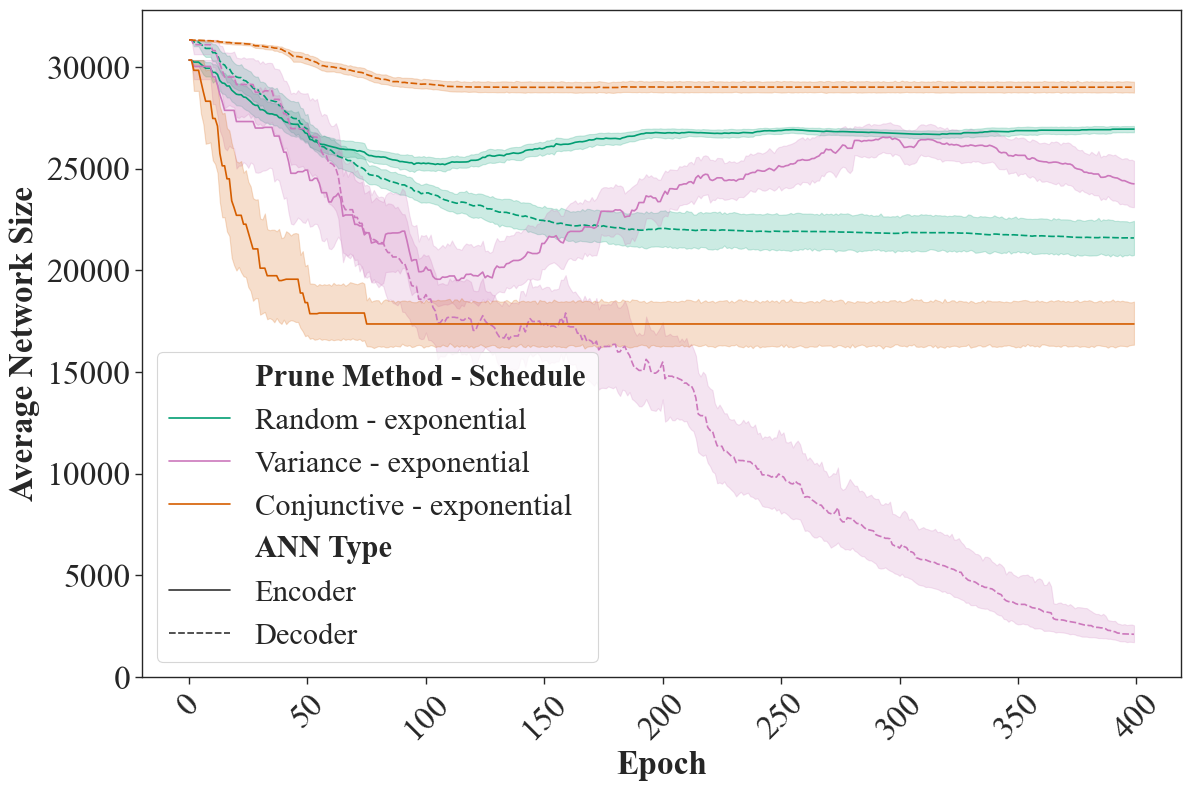

<Figure size 640x480 with 0 Axes>

In [18]:
param_dir = root_dir = "./paper_runs/best_of_canonical/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df


label_map = {
    lexi_name: lexi_name + " - exponential",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - exponential",
}
df["prune_method_schedule"] = df["prune_method"].replace(label_map)

color_prune_method_schedule = {
    label_map[lexi_name]: color_prune_method[lexi_name],
    label_map[random_name]: color_prune_method[random_name],
    label_map[activation_name]: color_prune_method[activation_name],
}

prune_methods = df["prune_method_schedule"].unique()
hue_order = [method for method in prune_methods if method != "None"]

df = df[df["prune_method"] != "None"]

df["type"] = "Encoder"
df["n_prune"] = enc_params - df["n_pruned_encoder"]
df2 = df.copy()
df2["type"] = "Decoder"
df2["n_prune"] = dec_params - df2["n_pruned_decoder"]
big_df = pd.concat([df, df2])

# Plot data

plt.figure(figsize=fig_size)

g = sns.lineplot(
    data=big_df,
    x="iteration",
    y="n_prune",
    hue="prune_method_schedule",
    hue_order=hue_order,
    palette=color_prune_method_schedule,
    style="type",
)

# # df['type'] = ["Decoder"]*df.shape[0]
# g = sns.lineplot(data=df2, x="iteration", y="n_pruned_decoder", hue="prune_method_schedule", hue_order=hue_order, palette=color_prune_method_schedule, style='type')
handles, labels = g.get_legend_handles_labels()


legend = plt.legend(
    handles=handles,
    labels=labels,
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

for text in legend.get_texts():
    if text.get_text() == "type":
        text.set_text("ANN Type")
        text.set_fontweight("bold")
    elif text.get_text() == "prune_method_schedule":
        text.set_text("Prune Method - Schedule")
        text.set_fontweight("bold")

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel(
    "Average Network Size", fontsize=font_size, fontweight="bold", fontname=font_name
)


plt.xticks(rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(n_prune_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_of_canonical_n_prune.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Network Preserved Percentage (Capacity) Boxplot for Best of Canonical, Lipi

100%|██████████| 121/121 [00:05<00:00, 22.11it/s]


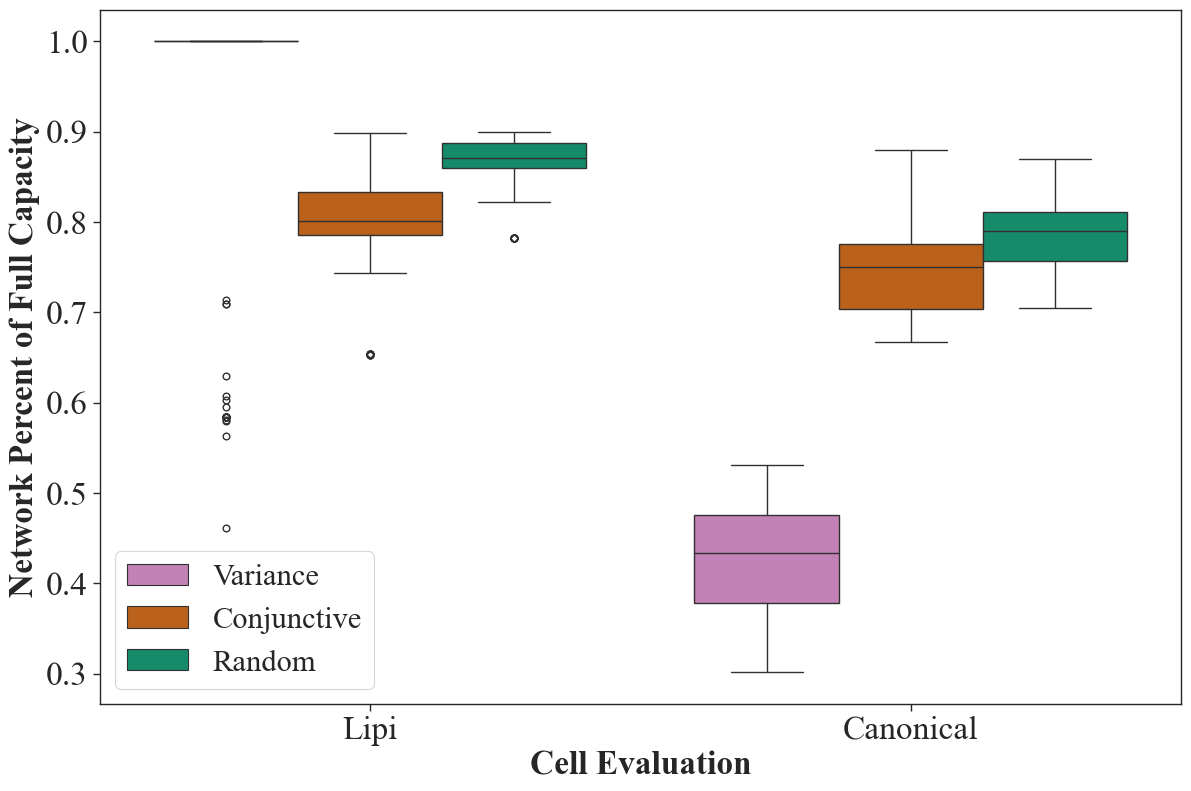

<Figure size 640x480 with 0 Axes>

In [20]:
param_dir = root_dir = "./paper_runs/best_of_lipi/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

l_main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
lipi_df = l_main_df

lipi_label_map = {
    lexi_name: lexi_name + " - final_n",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - population",
}
lipi_df["prune_method_schedule"] = lipi_df["prune_method"].replace(lipi_label_map)

param_dir = root_dir = "./paper_runs/best_of_canonical/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

c_main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
canon_df = c_main_df

canon_label_map = {
    lexi_name: lexi_name + " - exponential",
    random_name: random_name + " - exponential",
    activation_name: activation_name + " - exponential",
}
canon_df["prune_method_schedule"] = canon_df["prune_method"].replace(canon_label_map)

color_prune_method_schedule = {
    lipi_label_map[lexi_name]: palette[7],
    lipi_label_map[random_name]: color_prune_method[random_name],
    lipi_label_map[activation_name]: palette[8],
    canon_label_map[lexi_name]: color_prune_method[lexi_name],
    canon_label_map[random_name]: color_prune_method[random_name],
    canon_label_map[activation_name]: color_prune_method[activation_name],
}

lipi_df["Cell_Evaluation"] = "Lipi"
canon_df["Cell_Evaluation"] = "Canonical"

df = pd.concat([lipi_df, canon_df])


prune_methods = df["prune_method_schedule"].unique()
hue_order = [
    "Random - exponential",
    "Variance - population",
    "Conjunctive - exponential",
]  # sorted([method for method in prune_methods if method != 'None'])

df = df[df["prune_method"] != "None"]
df = df[df["iteration"] == df["iteration"].max()]

df["capacity"] = (
    (enc_params + dec_params) - (df["n_pruned_encoder"] + df["n_pruned_decoder"])
) / (enc_params + dec_params)

# df['type'] = "Encoder"
# df["n_prune"] = enc_params - df["n_pruned_encoder"]
# df2 = df.copy()
# df2["type"] = "Decoder"
# df2["n_prune"] = dec_params - df2["n_pruned_decoder"]
# big_df = pd.concat([df, df2])

# Plot data

plt.figure(figsize=fig_size)

g = sns.boxplot(
    data=df,
    x="Cell_Evaluation",
    y="capacity",
    hue="prune_method",
    palette=color_prune_method,
)


handles, labels = g.get_legend_handles_labels()


legend = plt.legend(
    handles=handles,
    labels=labels,
    title_fontsize=font_size - 1,
    prop={"family": font_name, "size": font_size - 2},
    loc="lower left",
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

# g.get_legend().legend_handles[i].set_hatch(hatches[i])

# for text in legend.get_texts():
#     if text.get_text() == "type":
#         text.set_text("ANN Type")
#         text.set_fontweight('bold')
#     elif text.get_text() == "prune_method_schedule":
#         text.set_text("Prune Method - Schedule")
#         text.set_fontweight('bold')

plt.xlabel("Cell Evaluation", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel(
    "Network Percent of Full Capacity",
    fontsize=font_size,
    fontweight="bold",
    fontname=font_name,
)


plt.xticks(fontsize=font_size, fontname=font_name)
plt.yticks(fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "box_capacity.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Best of Lipi vs Pruning After Training Boxplot

100%|██████████| 211/211 [00:12<00:00, 17.44it/s]


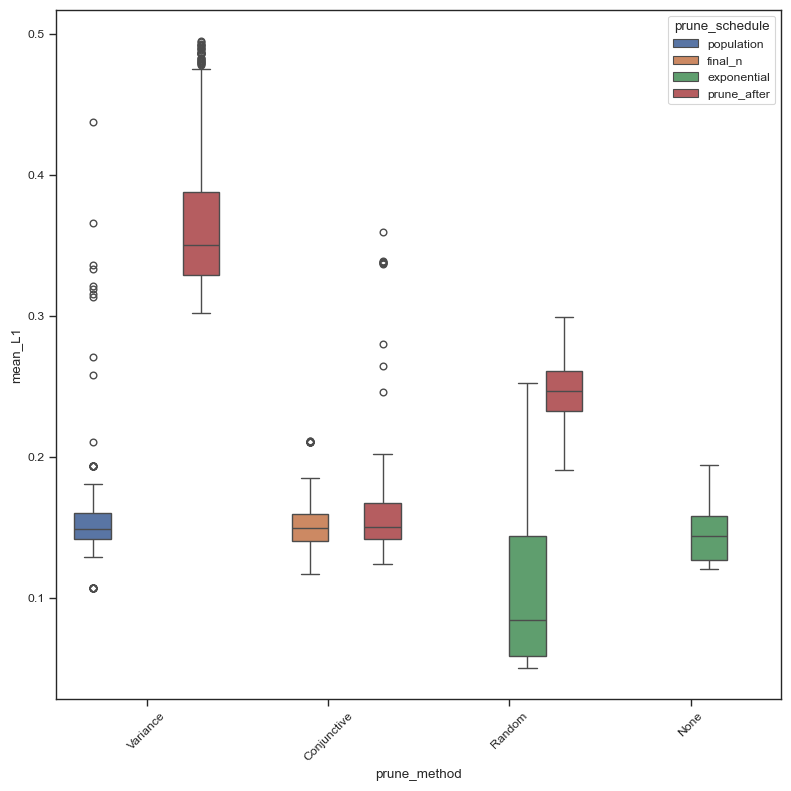

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot data
param_dir = root_dir = "./paper_runs/box_best_of_lipi/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

final_df = df[df["iteration"] == df["iteration"].max()]

# Plot quality
plt.figure(figsize=(8, 8))
sns.boxplot(
    data=final_df, x="prune_method", y="mean_L1", hue="prune_schedule"
)  # , palette=color_prune_schedule)
plt.xticks(rotation=45)
plt.tight_layout()
out_path = os.path.join(img_dir, "box_best_of_lipi_L1.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Best of Canonical vs Pruning After Training Boxplot

100%|██████████| 211/211 [00:09<00:00, 21.32it/s]


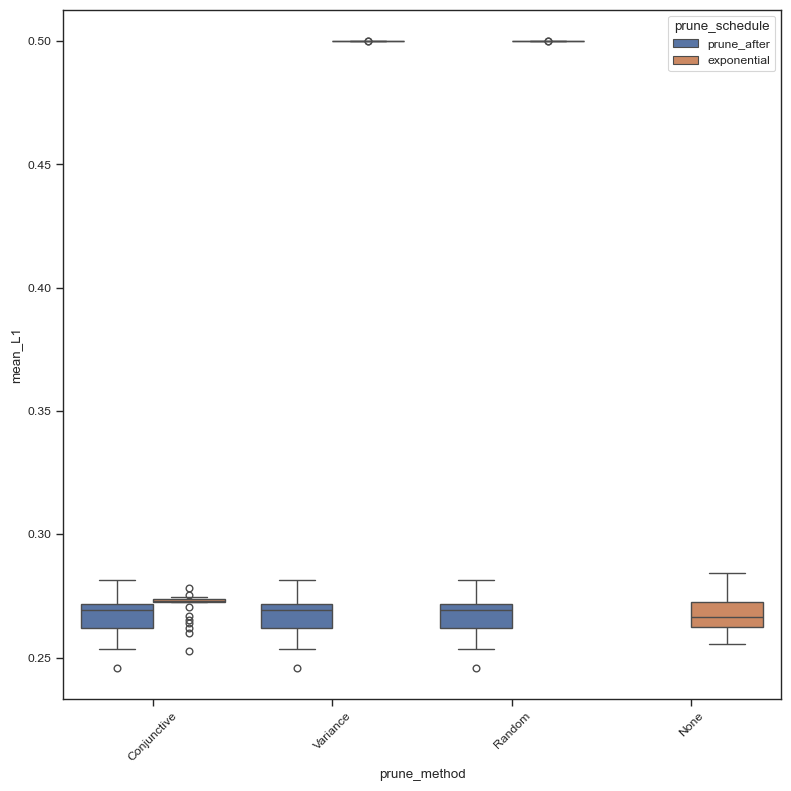

<Figure size 640x480 with 0 Axes>

In [22]:
param_dir = root_dir = "./paper_runs/box_best_of_canonical/"
configuration_files = get_configuration_files(param_dir)  # noqa: F821
name_map = {}

main_df, _, n_nodes = analyse_trials(  # noqa: F821
    root_dir, configuration_files, "GECCO_2025", name_map
)
df = main_df

final_df = df[df["iteration"] == df["iteration"].max()]

# Plot quality
plt.figure(figsize=(8, 8))
sns.boxplot(
    data=final_df, x="prune_method", y="mean_L1", hue="prune_schedule"
)  # , palette=color_prune_schedule)
plt.xticks(rotation=45)
plt.tight_layout()
out_path = os.path.join(img_dir, "box_best_of_canonical_L1.png")
plt.savefig(out_path)
plt.show()
plt.clf()

## Network Size of Best Individual in the population for Best of Lipi, Best of Lipi-Small, Best of Cannonical

100%|██████████| 90/90 [00:01<00:00, 78.16it/s]


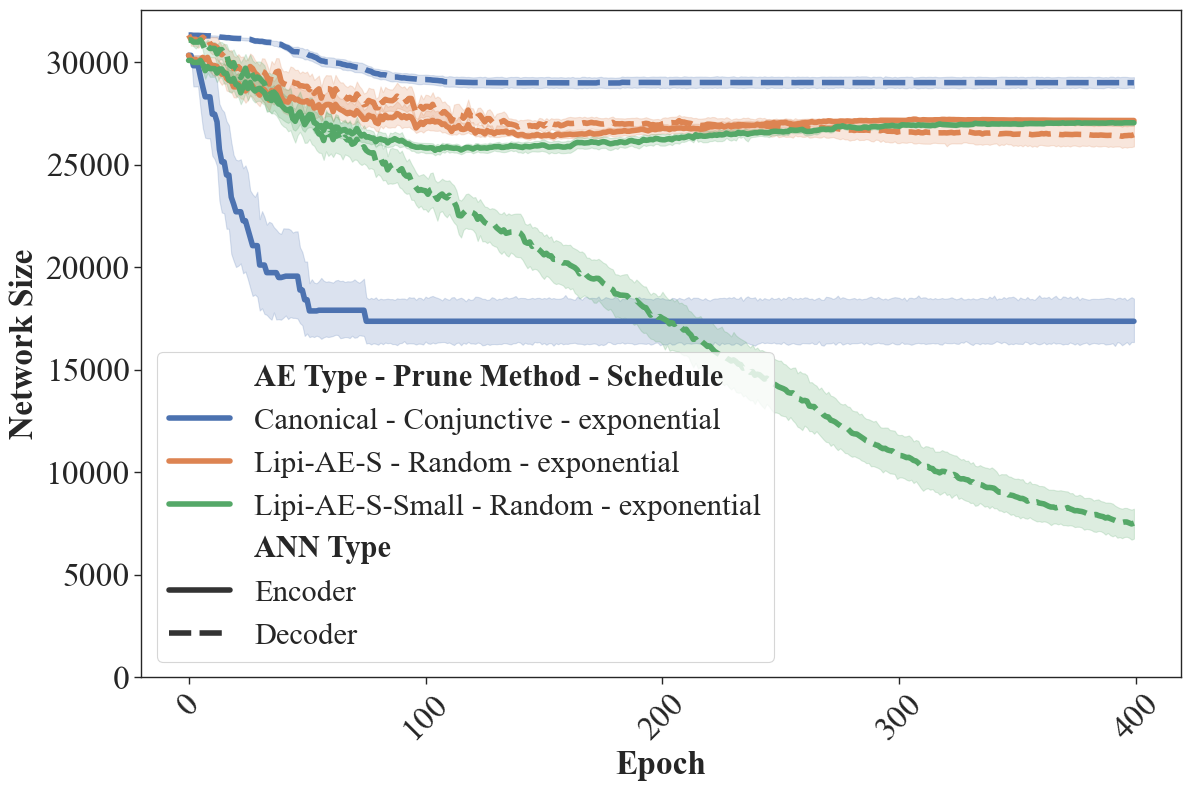

<Figure size 640x480 with 0 Axes>

In [23]:
root_dir = "./paper_runs/best_individual/"
configuration_files = get_configuration_files(root_dir)  # noqa: F821

dfs = []
for file_dir in tqdm(configuration_files.keys()):
    stats_path = os.path.join(root_dir, file_dir, "stats.jsonl")
    param_dir = os.path.join(root_dir, file_dir, "params.json")
    with open(stats_path, "r") as fd:
        stats = [json.loads(line) for line in fd]

    with open(param_dir, "r") as fd:
        params = json.load(fd)

    df = pd.DataFrame(stats)
    df["prune_method"] = params["prune_method"]
    df["prune_schedule"] = params["prune_schedule"]
    df["cell_evaluation"] = (
        params["cell_evaluation"] + params["environment"] + params["prune_method"]
    )

    temp_df = df[df["iteration"] == df["iteration"].max()]
    best_individual_idx = temp_df.loc[temp_df["mean_L1"].idxmin()]["node_idx"]

    df = df[df["node_idx"] == best_individual_idx]
    if "Small" in params["environment"]:
        df["enc_curr_size"] = (sm_enc_params) - (df["n_pruned_encoder"])
        df["dec_curr_size"] = (sm_dec_params) - (df["n_pruned_decoder"])
    else:
        df["enc_curr_size"] = (enc_params) - (df["n_pruned_encoder"])
        df["dec_curr_size"] = (dec_params) - (df["n_pruned_decoder"])
    dfs.append(df)

full_df = get_prune_method_names(pd.concat(dfs))
full_df.head()

full_df["cell_evaluation"] = full_df["cell_evaluation"].apply(
    lambda x: "Canonical - Conjunctive - exponential" if "lexicase" in x else x
)
full_df["cell_evaluation"] = full_df["cell_evaluation"].apply(
    lambda x: "Lipi-AE-S-Small - Random - exponential" if "Small" in x else x
)
full_df["cell_evaluation"] = full_df["cell_evaluation"].apply(
    lambda x: "Lipi-AE-S - Random - exponential" if "random" in x else x
)

full_df["type"] = "Encoder"
full_df["n_prune"] = full_df["enc_curr_size"]
full_df2 = full_df.copy()
full_df2["type"] = "Decoder"
full_df2["n_prune"] = full_df["dec_curr_size"]
combined_df = pd.concat([full_df, full_df2])

plt.figure(figsize=fig_size)

hue_order = sorted(full_df["cell_evaluation"].unique())

style_map = {"Encoder": "o", "Decoder": "X"}
markersize_map = {"Encoder": 6, "Decoder": 10} 

g = sns.lineplot(
    data=combined_df,
    x="iteration",
    y="n_prune",
    hue="cell_evaluation",
    hue_order=hue_order,
    style="type",
    # markers=style_map,
    linewidth=4
)

legend = plt.legend(
    title_fontsize=font_size - 1, prop={"family": font_name, "size": font_size - 2}
)
legend.get_title().set_fontweight("bold")
legend.get_title().set_fontname(font_name)

for text in legend.get_texts():
    if text.get_text() == "type":
        text.set_text("ANN Type")
        text.set_fontweight("bold")
    elif text.get_text() == "cell_evaluation":
        text.set_text("AE Type - Prune Method - Schedule")
        text.set_fontweight("bold")

plt.xlabel("Epoch", fontsize=font_size, fontweight="bold", fontname=font_name)
plt.ylabel("Network Size", fontsize=font_size, fontweight="bold", fontname=font_name)


plt.xticks(L1_epoch_ticks, rotation=45, fontsize=font_size, fontname=font_name)
plt.yticks(n_prune_ticks, fontsize=font_size, fontname=font_name)
plt.tight_layout()
out_path = os.path.join(img_dir, "best_individual_size_line.png")
plt.savefig(out_path)
plt.show()
plt.clf()


## AE Initial Network Size Calculation

In [24]:
from aes_lipi.environments.binary_clustering import (
    DecoderBinaryClustering,
    EncoderBinaryClustering,
    DecoderBinaryClusteringSmall,
    EncoderBinaryClusteringSmall,
)

In [25]:
kwargs = {"width": 1000, "height": 1, "x_dim": 1000}
a = DecoderBinaryClustering(**kwargs)

b = EncoderBinaryClustering(**kwargs)

In [26]:
print("Decoder Params:", get_n_params(a))
print("Encoder Params:", get_n_params(b))
print("Total Params:", get_n_params(a) + get_n_params(b))

Decoder Params: 31330
Encoder Params: 30340
Total Params: 61670


In [27]:
kwargs = {"width": 1000, "height": 1, "x_dim": 1000}
a = DecoderBinaryClusteringSmall(**kwargs)

b = EncoderBinaryClusteringSmall(**kwargs)

In [28]:
print("Small Decoder Params:", get_n_params(a))
print("Small Encoder Params:", get_n_params(b))
print("Small Total Params:", get_n_params(a) + get_n_params(b))

Small Decoder Params: 31090
Small Encoder Params: 30092
Small Total Params: 61182
